In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, auc
from IPython.display import clear_output
import os
import shutil
import re
from datetime import datetime, timedelta
import seaborn as sns
from jDataResultsAnalysis import explore_data_results, compare_data_results

In [14]:
# Load the original data
X = np.load('/home/jaleedkhan/ctg_dataset/X.npy')
y = np.load('/home/jaleedkhan/ctg_dataset/y.npy')
print(X.shape)
print(y.shape)

dataset = pd.read_csv('/home/jaleedkhan/ctg_dataset/clinical_data_new.csv')
dataset['input_signals'] = [x for x in X]
dataset['label'] = y.tolist()
print(dataset.shape)

(20589, 960, 2)
(20589,)
(20589, 21)


In [47]:
# print('FHR range:', np.min(X[:,:,0]), '-', np.max(X[:,:,0]), '; -1s:', np.sum(X[:,:,0] == -1)/X[:,:,0].size)
# print('TOCO range:', np.min(X[:,:,1]), '-', np.max(X[:,:,1]), '; -1s:', np.sum(X[:,:,1] == -1)/X[:,:,1].size)

# plt.figure(figsize=(12, 6))
# plt.subplot(2, 2, 1)
# plt.hist(X[:, :, 0].flatten(), bins=50, color='blue', alpha=0.7)
# plt.title('FHR Histogram')
# plt.subplot(2, 2, 2)
# plt.hist(X[:, :, 1].flatten(), bins=50, color='green', alpha=0.7)
# plt.title('TOCO Histogram')
# plt.tight_layout()
# plt.show()

__Clinical Variables:__

- _StudyID_B_: Anonymised, unique identifier for babies. 

- _OPAR1 (Viable Parity)_: Number of times the mother has given birth to a live baby after at least 24 weeks. A higher parity can influence maternal uterine contractility and CTG patterns. In the dataset, the range is 0-6 with a mean of 0.72, suggesting that most mothers have had few prior births. In cases, the mean is slightly lower at 0.71.

- _OPAR2 (Non-Viable Parity)_: Number of pregnancies reaching 24 weeks that did not result in a live birth. This may indicate a history of complicated pregnancies. In the dataset, the range is 0-14 with a mean of 0.47. In cases, the mean is 0.48, slightly higher than in the overall dataset.

- _Diff_: Duration, in hours, from CTG recording to birth. Prolonged labor can cause fetal distress, reflected in abnormal CTG patterns. The dataset has a wide range (0 to 2618 hours) with a mean of 390.44 hours. In cases, the mean is significantly lower at 62.35 hours, as this dataset contains only cases with CTGs recorded 7 days (0 - 168 hours) before birth. 

- _BMI_M_: Mother's BMI at the start of pregnancy. A higher BMI is linked to pregnancy complications and abnormal CTG patterns. In the dataset, BMI ranges from 15.42 to 40.00 with a mean of 25.86. In cases, the mean is slightly higher at 26.03.

- _OSEX (Baby's Sex)_: Baby's assigned sex (0 for male, 1 for female). Some studies suggest that male fetuses may have slightly different CTG patterns compared to females, particularly in response to labor stress. In the dataset, the sample is balanced (10,802 males and 9,787 females). In cases, 5,099 are male and 4,600 are female.

- _Perinatal Infections_: Indicates if the mother had infections during the perinatal period. Infections can lead to fetal distress and abnormal CTG patterns. In the dataset, infections are present in 3,215 cases.

- _Prolonged SCBU_: Whether the baby required extended special care after delivery. Babies requiring prolonged SCBU care might have had compromised conditions that were detectable on the CTG. In the dataset, 760 cases needed SCBU care. 

- _Acid1_: Measure of neonatal acidosis, an indicator of fetal hypoxia. It indicates the baby may not be getting enough oxygen. In the dataset, acidosis is present in 352 cases. 

- _Low Apgar_: Indicates if the newborn's Apgar score at 1 and 5 minutes after birth falls below normal thresholds, signaling health concerns. In the dataset, 543 cases show low Apgar scores.

- _Stillbirth_: Indicates if the baby was stillborn. Abnormal CTG patterns are often associated with cases of stillbirth, especially if there are signs of chronic hypoxia. In the dataset, there are 103 stillbirths.

- _Neonatal Sepsis_: Indicates if the baby developed sepsis shortly after birth. Sepsis can severely affect fetal heart rate patterns, potentially showing signs of infection and distress on the CTG. In the dataset, there are 68 cases of sepsis. 

- _HIE (Hypoxic-Ischemic Encephalopathy)_: Indicates if the newborn was diagnosed with HIE, a brain injury caused by limited oxygen during birth. HIE is present in 108 cases in the dataset.

- _Respiratory Conditions_: Indicates if the baby had respiratory complications. Respiratory distress is often correlated with abnormal CTG patterns, particularly decelerations in the fetal heart rate. In the dataset, 2,878 cases show respiratory issues.

- _Low Birth Weight_: Babies born with weight below the normal threshold. Low birth weight can be associated with intrauterine growth restriction (IUGR), which may lead to abnormal CTG readings. In the dataset, 4,164 cases show low birth weight. 

- _Asph1_: Indicates asphyxia at birth. Fetal asphyxia is a critical condition, often detectable through non-reassuring CTG patterns like late decelerations or reduced variability. In the dataset, 207 cases show asphyxia. 

- _ICD_B_10_: International Classification of Diseases, 10th Revision (ICD-10) codes assigned to the baby. These codes summarize the clinical diagnosis and outcomes, and they can help correlate specific CTG patterns with clinical diagnoses. The most common codes in the dataset include Z380 (17,390 samples), P073 (3,596 samples), and P071 (3,225 samples). In cases, Z380 (birth) occurs 6,500 times, P071 (preterm birth) 3,028 times, and P073 (fetal growth restriction) 2,862 times. In controls, Z380 (birth) occurs 10,890 times, with other codes like Z038 (observations without diagnosis) and P599 (disorders of blood) also appearing frequently.
blood) also appearing frequently.


----------------------------------- Dataset ------------------------------------
Count: 20589



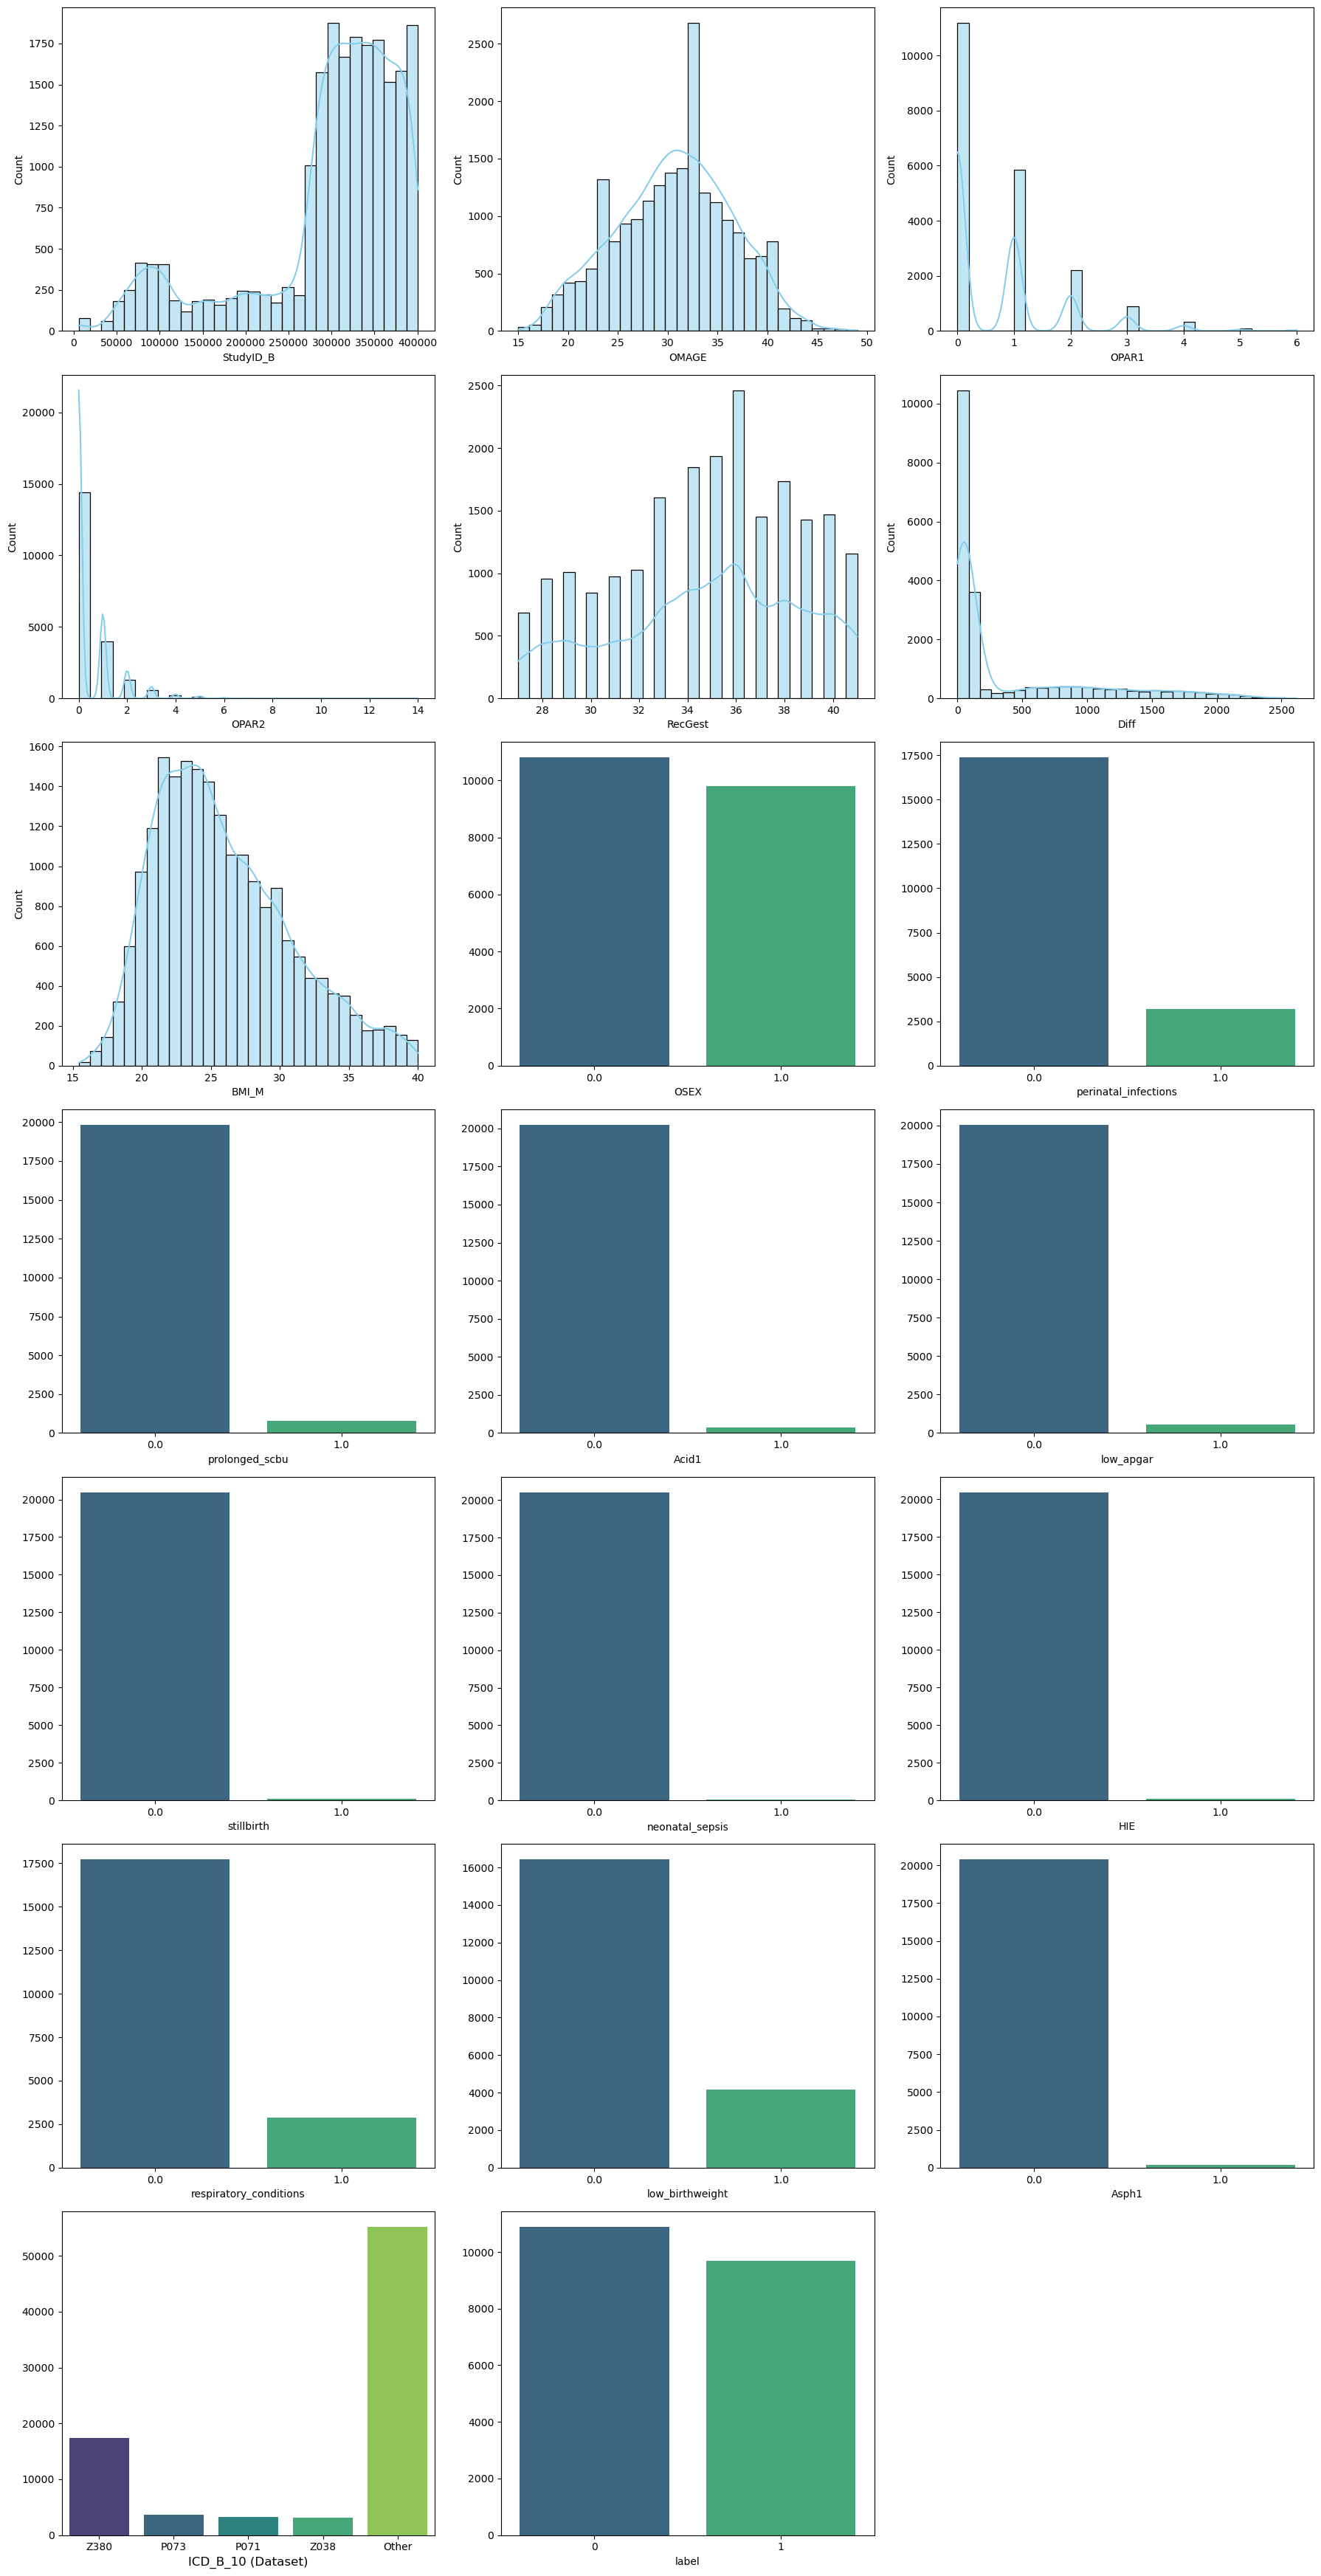

                Column Type/Unique Values                                                                         Details
             StudyID_B            Numeric Min: 5716.00, Max: 400504.00, Mean: 298226.93, Median: 321221.00, Std: 89344.72
                 OMAGE            Numeric                   Min: 15.00, Max: 49.00, Mean: 30.65, Median: 31.00, Std: 5.82
                 OPAR1            Numeric                       Min: 0.00, Max: 6.00, Mean: 0.72, Median: 0.00, Std: 1.00
                 OPAR2            Numeric                      Min: 0.00, Max: 14.00, Mean: 0.47, Median: 0.00, Std: 0.91
               RecGest            Numeric                   Min: 27.00, Max: 41.00, Mean: 34.81, Median: 35.00, Std: 3.85
                  Diff            Numeric               Min: 0.00, Max: 2618.00, Mean: 390.44, Median: 84.00, Std: 580.80
                 BMI_M            Numeric                   Min: 15.42, Max: 40.00, Mean: 25.86, Median: 24.94, Std: 4.85
                  OSEX  

In [16]:
explore_data_results(dataset, plots=True)

In [35]:
# compare_data_results(dataset[dataset['label']==1],dataset[dataset['label']==0], names=['Cases','Controls'])

In [18]:
# Manually set results_dir if needed 
results_dir = None #'PatchTST_supervised/jResults/20240905 1259'

# Set results_dir to the most recent one
if results_dir is None:
    subdirs = [d for d in os.listdir('PatchTST_supervised/jResults/') if os.path.isdir(os.path.join('PatchTST_supervised/jResults/', d))]
    valid_dirs = []
    for subdir in subdirs:
        try:
            datetime.strptime(subdir, '%Y%m%d %H%M')
            valid_dirs.append(subdir)
        except ValueError:
            continue
    valid_dirs_sorted = sorted(valid_dirs, key=lambda x: datetime.strptime(x, '%Y%m%d %H%M'))
    if valid_dirs_sorted:
        results_dir = os.path.join('PatchTST_supervised/jResults/', valid_dirs_sorted[-1])
print(results_dir)

# Load the split dataset, logs and results 
train_df = pd.read_csv(os.path.join(results_dir, 'dataset_train.csv'))
test_df = pd.read_csv(os.path.join(results_dir, 'dataset_test.csv'))
preds = np.load(os.path.join(results_dir, 'preds.npy'))
trues = np.load(os.path.join(results_dir, 'trues.npy'))
with open(os.path.join(results_dir, 'PatchTST_ctg_960.log'), 'r') as log_file:
    log_data = log_file.read()

PatchTST_supervised/jResults/20240911 1135


In [19]:
explore_data_results(train_df, name='train')
explore_data_results(test_df, name='test')

------------------------------------ train -------------------------------------
Count: 16471

                Column Type/Unique Values                                                                         Details
             StudyID_B            Numeric Min: 5716.00, Max: 400504.00, Mean: 297964.03, Median: 320641.00, Std: 89497.00
                 OMAGE            Numeric                   Min: 15.00, Max: 49.00, Mean: 30.64, Median: 31.00, Std: 5.82
                 OPAR1            Numeric                       Min: 0.00, Max: 6.00, Mean: 0.72, Median: 0.00, Std: 1.00
                 OPAR2            Numeric                      Min: 0.00, Max: 14.00, Mean: 0.47, Median: 0.00, Std: 0.91
               RecGest            Numeric                   Min: 27.00, Max: 41.00, Mean: 34.82, Median: 35.00, Std: 3.85
                  Diff            Numeric               Min: 0.00, Max: 2618.00, Mean: 388.44, Median: 82.00, Std: 579.83
                 BMI_M            Numeric          

In [20]:
# compare_data_results(train_df[train_df['label']==1],train_df[train_df['label']==0], 
#                      test_df[test_df['label']==1],test_df[test_df['label']==0],
#                      names=['train-case','train-control','test-case','test-control'])

******************** Hyperparameters ********************
activation: gelu
affine: 0
batch_size: 16
c_out: 1
checkpoints: ./checkpoints/ctg
d_ff: 128
d_layers: 1
d_model: 128
data: CTG
data_path: X.npy
dec_in: 2
decomposition: 0
des: Exp
devices: 0,1,2,3
distil: True
do_predict: False
dropout: 0.3
e_layers: 4
embed: timeF
embed_type: 0
enc_in: 2
factor: 1
fc_dropout: 0.3
features: M
freq: h
gpu: 0
head_dropout: 0.1
individual: 0
is_optuna: False
is_training: 1
itr: 1
kernel_size: 25
learning_rate: 6.99e-05
loss: cross_entropy
lradj: type3
model: PatchTST
model_id: ctg_960
moving_avg: 25
n_heads: 8
num_classes: 2
num_workers: 10
output_attention: False
padding_patch: end
patch_len: 16
patience: 15
pct_start: 0.3
random_seed: 2021
revin: 1
root_path: ./dataset/
seq_len: 960
stride: 8
subtract_last: 0
target: OT
test_flop: False
train_epochs: 50
use_amp: False
use_gpu: True
use_multi_gpu: False

******************* Training Results ********************

Total Training Time: 0:20:20.531478

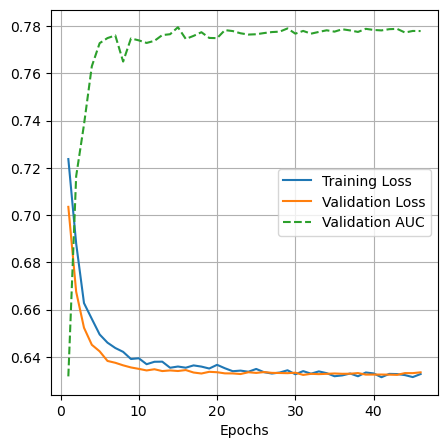


******************** Testing Results ********************
Accuracy: 0.72
Precision: 0.84
Recall: 0.49
F1 Score: 0.62
AUC: 0.78


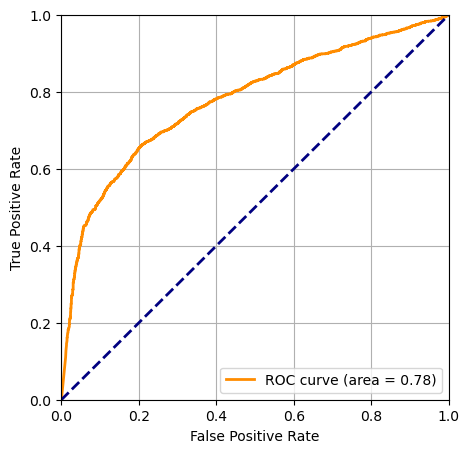

In [23]:
# Initialize variables to store log data
hyperparameters = {}
train_losses = []
val_losses = []
val_aucs = []
epochs = []
train_times = []
test_metrics = None

# Parse the log data directly from the variable
lines = log_data.splitlines()
for i, line in enumerate(lines):
    if i == 1 and line.startswith("Namespace("):
        hyperparameter_string = line.strip().replace("Namespace(", "").replace(")", "")
        hyperparameter_pairs = hyperparameter_string.split(", ")
        for item in hyperparameter_pairs:
            if "=" in item:
                key, value = item.split("=", 1)
                hyperparameters[key.strip()] = value.strip().strip("'")  # Remove quotes around string values

    # Extract training/validation losses and validation auc
    if "Train Loss" in line:
        match = re.findall(r'Epoch: (\d+).*Train Loss: ([\d.]+) Vali Loss: ([\d.]+) Vali AUC: ([\d.]+)', line)
        if match:
            epoch, train_loss, val_loss, val_auc = match[0]
            epochs.append(int(epoch))
            train_losses.append(float(train_loss))
            val_losses.append(float(val_loss))
            val_aucs.append(float(val_auc))
    
    # Extract training time
    if "cost time" in line:
        match = re.findall(r'Epoch: (\d+) cost time: ([\d.]+)', line)
        if match:
            epoch, time_taken = match[0]
            train_times.append(float(time_taken))
    
    # Extract final test metrics
    if "accuracy" in line:
        match = re.findall(r'accuracy:([\d.]+), precision:([\d.]+), recall:([\d.]+), f1:([\d.]+), auc:([\d.]+)', line)
        if match:
            accuracy, precision, recall, f1, auc_score = match[0]
            test_metrics = {
                'Accuracy': float(accuracy),
                'Precision': float(precision),
                'Recall': float(recall),
                'F1 Score': float(f1),
                'AUC': float(auc_score)
            }

print("******************** Hyperparameters ********************")
for key, value in hyperparameters.items():
    print(f"{key}: {value}")

print("\n******************* Training Results ********************")

# Calculate and print total training time
total_train_time = sum(train_times)
train_time_hms = str(timedelta(seconds=total_train_time))
print(f"\nTotal Training Time: {train_time_hms}")

# Plot the training and validation losses
plt.figure(figsize=(5, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, val_aucs, label='Validation AUC', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Print the final test results
if test_metrics:
    print("\n******************** Testing Results ********************")
    for metric, value in test_metrics.items():
        print(f"{metric}: {np.round(value, decimals=2)}")

# Compute ROC curve and AUC using already loaded preds and trues
fpr, tpr, _ = roc_curve(trues, preds)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

49.00627615062761% cases correctly classified
91.97642792384406% controls correctly classified
--------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


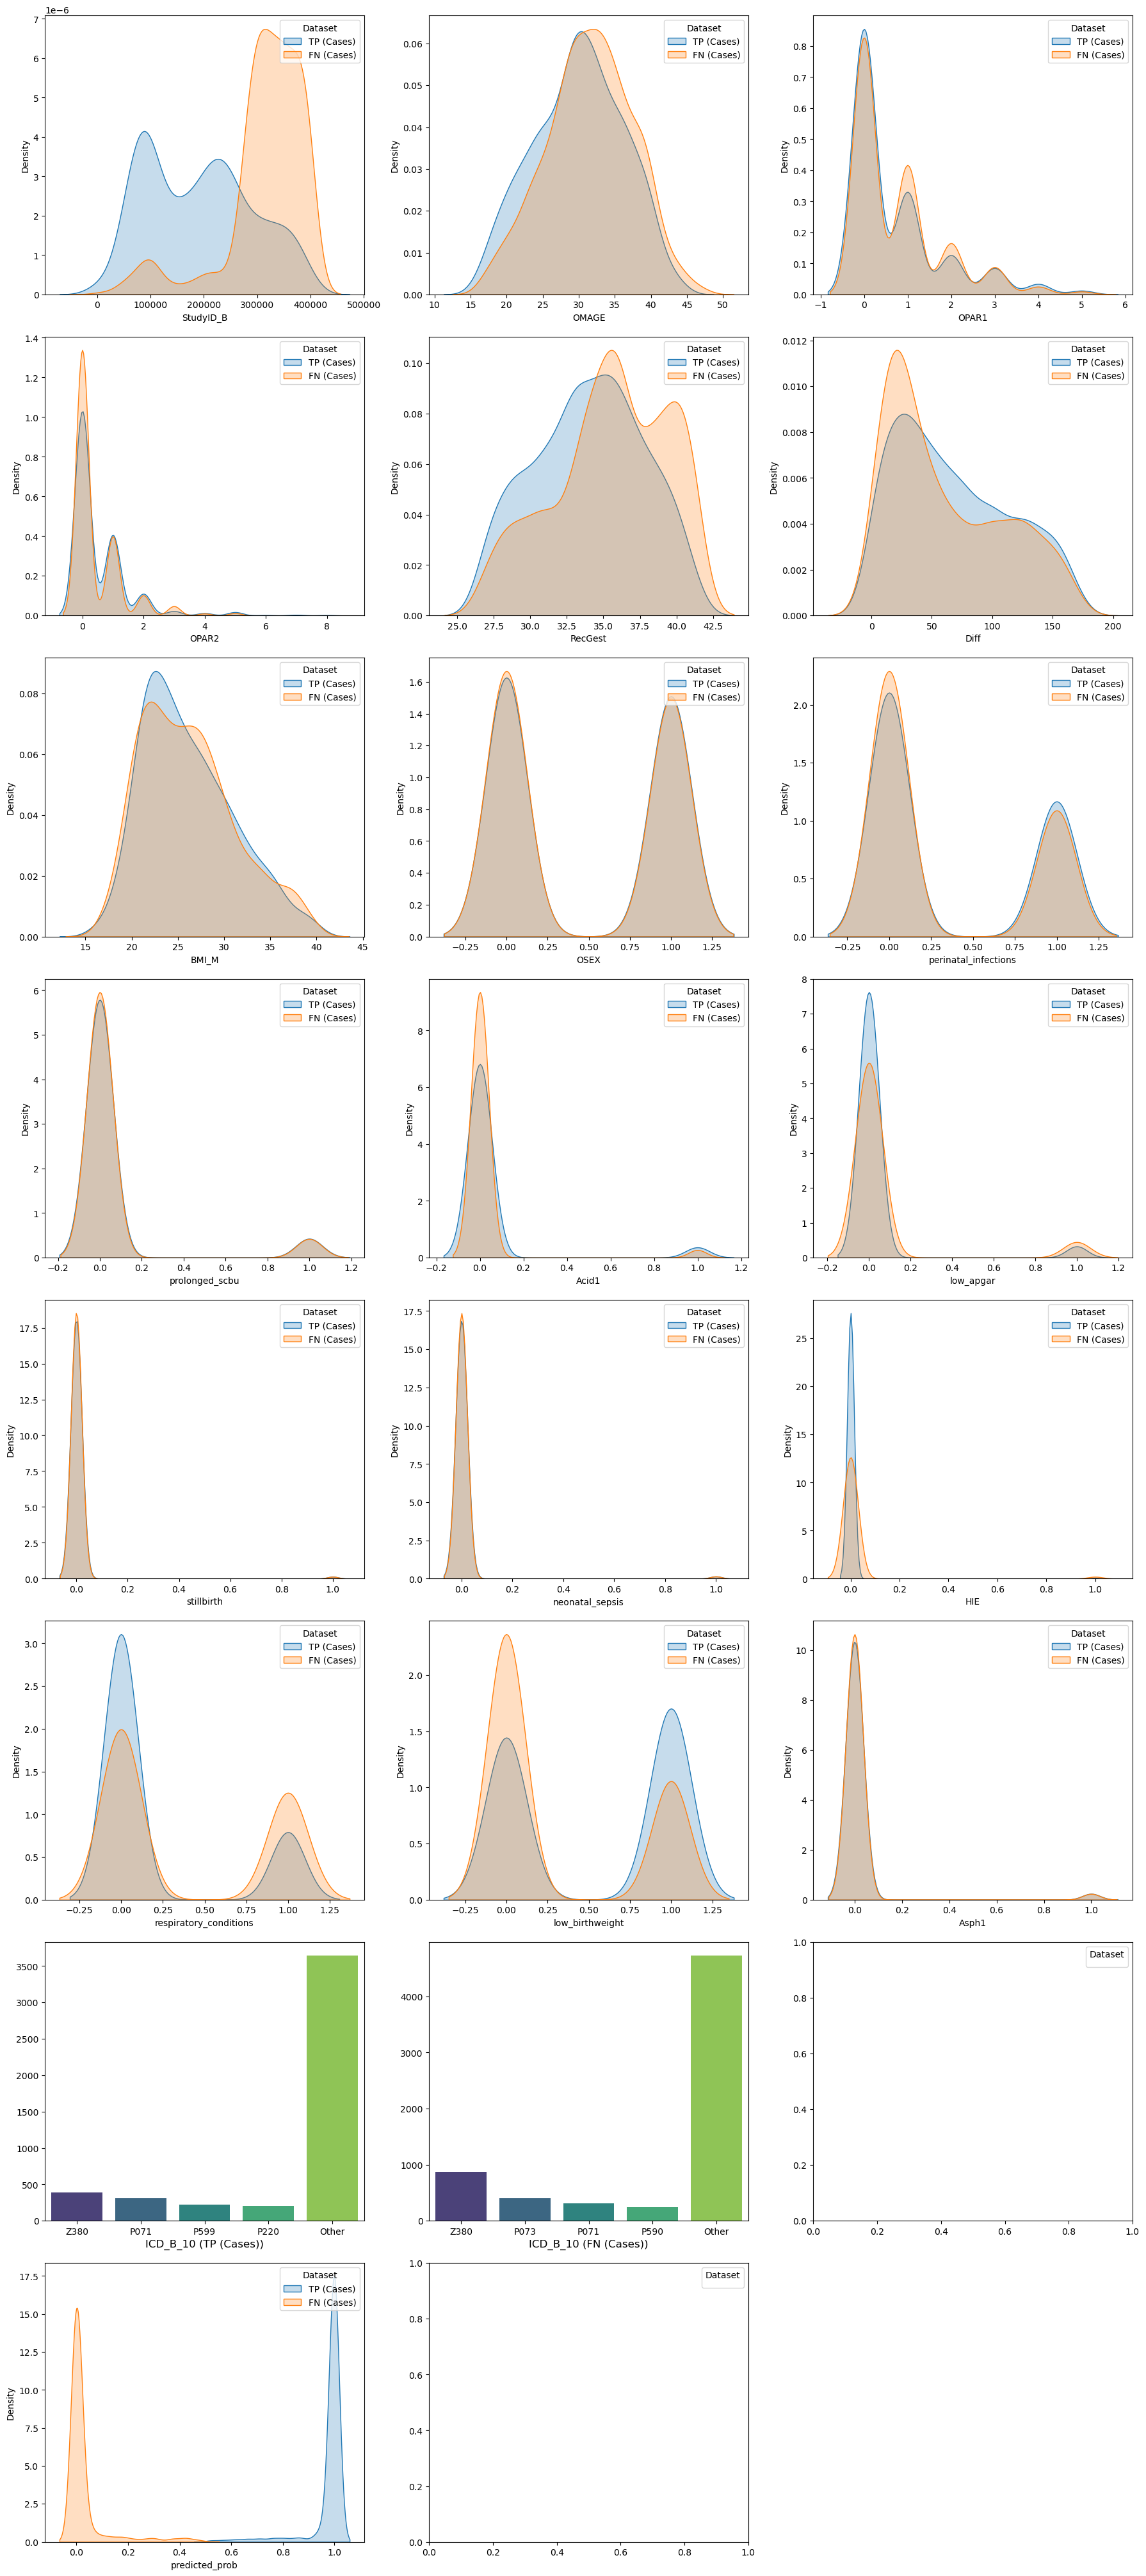

---------------------------------- TP (Cases) ----------------------------------
Count: 937

                Column Type/Unique Values                                                                         Details
             StudyID_B            Numeric Min: 5716.00, Max: 397447.00, Mean: 190755.70, Median: 194307.00, Std: 99497.16
                 OMAGE            Numeric                   Min: 16.00, Max: 44.00, Mean: 29.98, Median: 30.00, Std: 6.18
                 OPAR1            Numeric                       Min: 0.00, Max: 5.00, Mean: 0.72, Median: 0.00, Std: 1.09
                 OPAR2            Numeric                       Min: 0.00, Max: 8.00, Mean: 0.54, Median: 0.00, Std: 0.98
               RecGest            Numeric                   Min: 27.00, Max: 41.00, Mean: 34.00, Median: 34.00, Std: 3.70
                  Diff            Numeric                  Min: 1.00, Max: 168.00, Mean: 67.64, Median: 58.00, Std: 46.87
                 BMI_M            Numeric            

In [39]:
# Add the results to test_df
predicted_probs = preds.flatten()
predicted_labels = (predicted_probs > 0.5).astype(int)
test_df = test_df[:len(preds)]
test_df['predicted_prob'] = predicted_probs
test_df['predicted_label'] = predicted_labels

# Filtering by correctly classified and misclassified samples, as well as by label
test_cases = test_df[test_df['label'] == 1]
test_controls = test_df[test_df['label'] == 0]
correctly_classified_cases = test_df[(test_df['label'] == 1) & (test_df['label'] == test_df['predicted_label'])]
correctly_classified_controls = test_df[(test_df['label'] == 0) & (test_df['label'] == test_df['predicted_label'])]
misclassified_cases = test_df[(test_df['label'] == 1) & (test_df['label'] != test_df['predicted_label'])]
misclassified_controls = test_df[(test_df['label'] == 0) & (test_df['label'] != test_df['predicted_label'])]

print(f"{100*len(correctly_classified_cases)/len(test_cases)}% cases correctly classified")
print(f"{100*len(correctly_classified_controls)/len(test_controls)}% controls correctly classified")
print('-'*20)

# compare_data_results(correctly_classified_cases, misclassified_cases,
#                      correctly_classified_controls, misclassified_controls,
#                      names=['true-cases','false-cases','true-controls','false-controls'])

compare_data_results(correctly_classified_cases, misclassified_cases,
                     names=['TP (Cases)','FN (Cases)'])
explore_data_results(test_cases, name='Test (Cases)')

Diff < 168: AUC: 0.78, Accuracy: 0.72, Precision: 0.84, Recall: 0.49, F1-score: 0.62
Diff < 144: AUC: 0.77, Accuracy: 0.73, Precision: 0.83, Recall: 0.49, F1-score: 0.61
Diff < 120: AUC: 0.77, Accuracy: 0.74, Precision: 0.81, Recall: 0.48, F1-score: 0.61
Diff < 96: AUC: 0.77, Accuracy: 0.75, Precision: 0.79, Recall: 0.48, F1-score: 0.60
Diff < 72: AUC: 0.76, Accuracy: 0.76, Precision: 0.75, Recall: 0.46, F1-score: 0.57
Diff < 48: AUC: 0.75, Accuracy: 0.78, Precision: 0.69, Recall: 0.44, F1-score: 0.53
Diff < 24: AUC: 0.73, Accuracy: 0.83, Precision: 0.52, Recall: 0.41, F1-score: 0.46


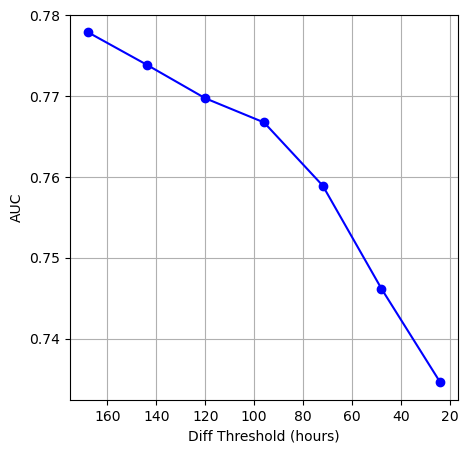

In [40]:
def calculate_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

# List of thresholds for 'Diff'
thresholds = [7*24, 6*24, 5*24, 4*24, 3*24, 2*24, 1*24]

auc_values = []

# Iterate over thresholds to evaluate the performance
for threshold in thresholds:
    subset_df = test_df[(test_df['label'] == 0) | ((test_df['label'] == 1) & (test_df['Diff'] < threshold))]
    subset_name = f"Diff < {threshold}"
    
    y_pred_classes_optimized = np.array(subset_df['predicted_label'].values)
    y_pred_prob = np.array(subset_df['predicted_prob'].values).ravel()
    y_true = np.array(subset_df['label'].values).astype(int)

    auc = roc_auc_score(y_true, y_pred_prob)
    accuracy = accuracy_score(y_true, y_pred_classes_optimized)
    precision = precision_score(y_true, y_pred_classes_optimized)
    recall = recall_score(y_true, y_pred_classes_optimized)
    f1 = calculate_f1(precision, recall)

    auc_values.append(auc)
    
    print(f"{subset_name}: AUC: {auc:.2f}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")

# Plotting the AUC values against the thresholds
plt.figure(figsize=(5, 5))
plt.plot(thresholds, auc_values, marker='o', linestyle='-', color='b')
plt.xlabel('Diff Threshold (hours)')
plt.ylabel('AUC')
plt.gca().invert_xaxis()  # Invert x-axis to show decreasing thresholds from left to right
plt.grid(True)
plt.show()